# Proyecto de Segmentación y Clasificación de úlceras corneales

# Avance 1. Análisis exploratorio de datos



**INTEGRANTES**:

*   Erick Alexei Cambray Servin 	 A01794243
*   Walter André Hauri Rosales 	   A01794237
*   Zmaltzin Paola Godinez Juárez  A01794538

**SECUENCIA Y CONTENIDO**

1. Definición del espacio de trabajo
2. Métodos de Segmentación

    2.1. Segmentation sin supervisión

    
3. Extracción of características Regionales

# 1. Workspace definition


Todas las imagenes son descargadas del repositorio de GitHub:
https://github.com/CRazorback/The-SUSTech-SYSU-dataset-for-automatically-segmenting-and-classifying-corneal-ulcers

Primero, se seleccionaron 6 imágenes de referencia del dataset conformado por 754 en intervalos de 100 imágenes, con ejemplos de úlceras corneales mostrando diferentes grados de severidad. Una vez seleccionadas son importadas a Google Colab platform para ser desplegadas y observar sus características generales, además de las similitudes y diferencias entre ellas:

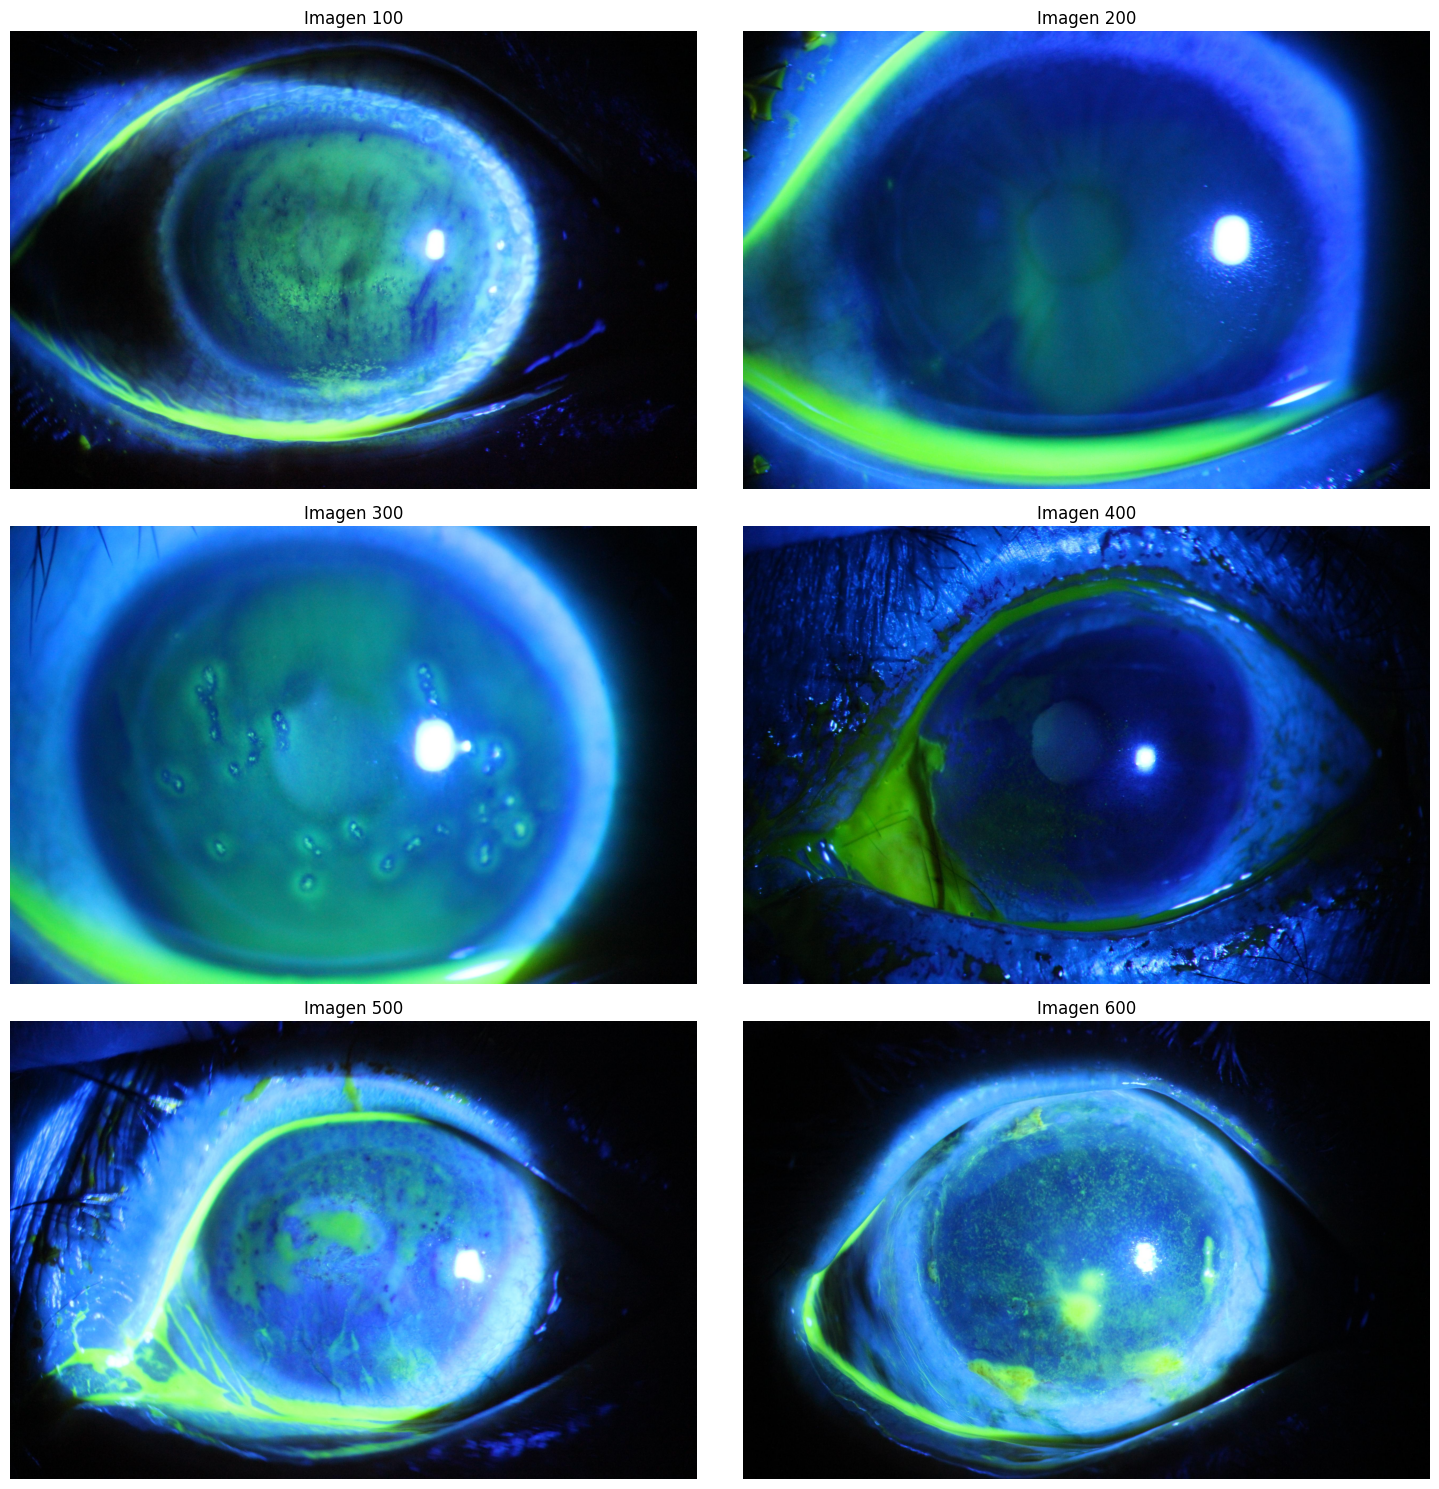

In [2]:
import os

import matplotlib.pyplot as plt
import skimage as sk
from matplotlib import gridspec
from skimage import io

# Path of the folder in your google drive unit where you have the images:
path = os.path.join("../data/SUSTechStudy", "rawImages")

I100 = sk.io.imread(os.path.join(path, "100.jpg"))
I200 = sk.io.imread(os.path.join(path, "200.jpg"))
I300 = sk.io.imread(os.path.join(path, "300.jpg"))
I400 = sk.io.imread(os.path.join(path, "400.jpg"))
I500 = sk.io.imread(os.path.join(path, "500.jpg"))
I600 = sk.io.imread(os.path.join(path, "600.jpg"))

fig = plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(3, 2)

ax0 = fig.add_subplot(gs[0, 0])
ax0.imshow(I100, cmap=plt.cm.gray)
ax0.set_title("Imagen 100")
ax0.set_axis_off()

ax1 = fig.add_subplot(gs[0, 1])
ax1.imshow(I200, cmap=plt.cm.gray)
ax1.set_title("Imagen 200")
ax1.set_axis_off()

ax2 = fig.add_subplot(gs[1, 0])
ax2.imshow(I300, cmap=plt.cm.gray)
ax2.set_title("Imagen 300")
ax2.set_axis_off()

ax3 = fig.add_subplot(gs[1, 1])
ax3.imshow(I400, cmap=plt.cm.gray)
ax3.set_title("Imagen 400")
ax3.set_axis_off()

ax4 = fig.add_subplot(gs[2, 0])
ax4.imshow(I500, cmap=plt.cm.gray)
ax4.set_title("Imagen 500")
ax4.set_axis_off()

ax5 = fig.add_subplot(gs[2, 1])
ax5.imshow(I600, cmap=plt.cm.gray)
ax5.set_title("Imagen 600")
ax5.set_axis_off()

plt.tight_layout()
plt.show()

Para checar el tamaño de la imagen in pixeles y el número de canales para la primera imagen del subconjunto:

In [3]:
print(I100.shape)

(1728, 2592, 3)


Ahora podemos checar cuantos bits son usados para codificar los niveles de intensidad de cada pixel para la misma imagen:

In [4]:
I100.dtype

dtype('uint8')

De las imágenes seleccionadas es importante resaltar que los números 100, 200 y 300 no presentan una lesión detectada durante el estudio de Wang, et al., (2021). De las 3 imágenes restantes la que presenta más de una lesión de acuerdo a la segmentación determinada por este estudio es la imagen 600, por lo que será utilizada para llevar a cabo los análisis posteriores. A continuación se muestra la delimitación de la córnea y la segmentación de las úlceras del estudio de referencia para la imagen seleccionada (600).


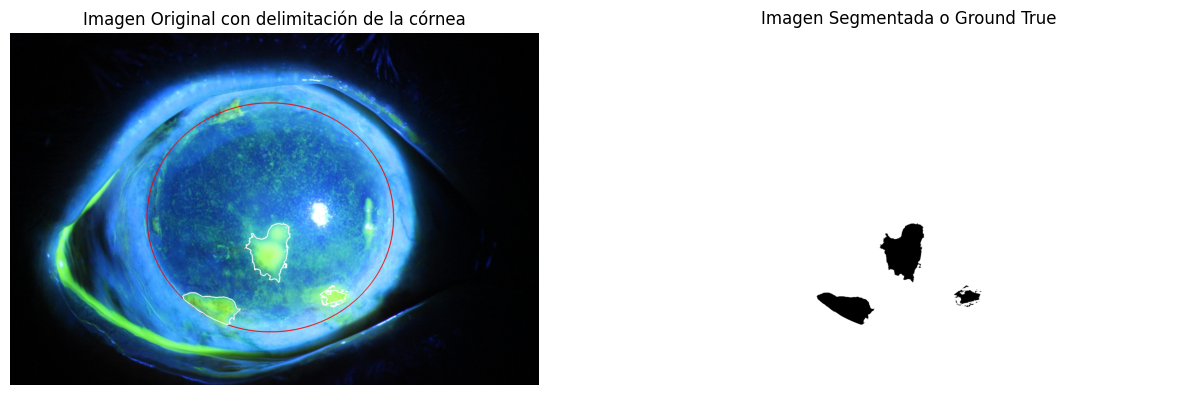

In [5]:
# Imagen con el overlay de la delimitación de la córnea (OV) y la segmentación de las úlceras correspondientes
I600_GT = sk.io.imread(os.path.join(path, "600_GT.png"))
I600_OV = sk.io.imread(os.path.join(path, "600_overlay.jpg"))
I600_circle_gt = sk.io.imread(os.path.join(path, "I600_circle_gt.png"))

fig = plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(1, 2)

ax1 = fig.add_subplot(gs[0, 0])
ax1.imshow(I600_OV, cmap=plt.cm.gray)
ax1.set_title("Imagen Original con delimitación de la córnea")
ax1.set_axis_off()

ax2 = fig.add_subplot(gs[0, 1])
ax2.imshow(I600_GT, cmap=plt.cm.gray)
ax2.set_title("Imagen Segmentada o Ground True")
ax2.set_axis_off()

plt.show()


Para poder evaluar el trabajo de los métodos de segmentación convencionales es necesario limitar el análisis a la sección asociada a la córnea, por lo que los subsecuentes despliegues de la imagen serán limitados a esta sección o área.

# 2. Segmentation de Imágenes

# Segmentación de imágenes: implemenación sin Supervisión

Info:
https://healthdataminer.com/data-mining/aprendizaje-supervisado-y-no-supervisado/

El objetivo principal de la segmentación de imágenes es el identificar un patrón de interés del background o fondo de la imagen. Para este estudio, las imágenes necesitan separar los pixeles que pertenecen al background y los pixeles que corresponden al patrón de interés o las úlceras en la córnea.


## 2.1. Segmentación No Supervisada

Se revisarán los siguientes métodos para tomar como referencia y comparación a la segmentación realizada por el método aplicado por Wang et al., (2021):

- Otsu's algorithm

- K-means clustering


### Otsu's algorithm

Link: https://muthu.co/otsus-method-for-image-thresholding-explained-and-implemented/

Como referencia, primero se aplica el método de Otsu como aproximación de referencia. Este algoritmo busca el umbral que maximiza la varianza entre clases o **maximum inter-class variance** $\sigma _{b}^{2}(t)$, definido en términos de la diferencia entre los promedios de los clusters en el histograma de la imagen (patrón y background, respectivamente):

$\sigma _{b}^{2}(t)=\omega _{0}(t)\omega _{1}(t)\left[\mu _{0}(t)-\mu _{1}(t)\right]^{2}$

El algoritmo es el siguiente:

1. Calcular el histograma y las probabilidades de cada nivel de intensidad $p(i), i=0,\dots L$ donde $L=2^n$ para un n-bit de la imagen en grises.

2. Asocia un valor inicial de $\omega _{i}(0)$ and $\mu _{i}(0)$

3. Busca entre todos los umbrales posibles $t=1,\ldots L-1$

a) Actualiza $\omega _{i}$ and $\mu _{i}$


$\omega _{0}(t)=\sum _{i=0}^{t-1}p(i)$

$\omega _{1}(t)=\sum _{i=t}^{L-1}p(i)$

$\mu _{0}(t)={\frac {\sum _{i=0}^{t-1}ip(i)}{\omega _{0}(t)}}$

$\mu _{1}(t)={\frac {\sum _{i=t}^{L-1}ip(i)}{\omega _{1}(t)}}$

b) Calcula $\sigma _{b}^{2}(t)=\omega _{0}(t)\omega _{1}(t)\left[\mu _{0}(t)-\mu _{1}(t)\right]^{2}$

4. El umbral deseado corresponde al que maximiza la varianza entre clases $\sigma _{b}^{2}(t)$

In [59]:
import cv2
import numpy as np
import os

# Cargar la imagen original y la máscara de la córnea
imagen_ojo = cv2.imread(os.path.join(path, "600.jpg"))
mascara_cornea = cv2.imread(
    os.path.join(path, "I600_circle_gt.png"), cv2.IMREAD_GRAYSCALE
)

# Encontrar los contornos de la máscara (los píxeles negros)
contornos, _ = cv2.findContours(
    255 - mascara_cornea, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
)

# Extraer el contorno más grande (suponiendo que es la máscara de la córnea)
x, y, w, h = cv2.boundingRect(contornos[0])

# Recortar la imagen original para que contenga solo el área de la máscara
imagen_recortada = imagen_ojo[y : y + h, x : x + w]

# Crear una nueva imagen con fondo blanco del tamaño de la máscara
resultado = np.full((h, w, 3), 255, dtype=np.uint8)  # Imagen blanca

# Aplicar la máscara para conservar solo la parte de la imagen correspondiente a la córnea
resultado[mascara_cornea[y : y + h, x : x + w] == 0] = imagen_recortada[
    mascara_cornea[y : y + h, x : x + w] == 0
]

# Guardar la imagen resultante
cv2.imwrite(os.path.join(path, "I600_circle.jpg"), resultado)

True

In [44]:
import cv2
import numpy as np
import os

# Cargar la imagen original y la máscara de la córnea
imagen_ojo = cv2.imread(os.path.join(path, "600.jpg"))
mascara_cornea = cv2.imread(
    os.path.join(path, "I600_circle_gt.png"), cv2.IMREAD_GRAYSCALE
)

# Encontrar los contornos de la máscara (los píxeles negros)
contornos, _ = cv2.findContours(
    255 - mascara_cornea, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
)

# Extraer el contorno más grande (suponiendo que es la máscara de la córnea)
x, y, w, h = cv2.boundingRect(contornos[0])

# Recortar la imagen original para que contenga solo el área de la máscara
imagen_recortada = imagen_ojo[y : y + h, x : x + w]

# Recortar la máscara también
mascara_recortada = mascara_cornea[y : y + h, x : x + w]

# Crear una nueva imagen con fondo blanco del tamaño de la región recortada
resultado = np.full_like(
    imagen_recortada, 255
)  # Inicializar el fondo con píxeles blancos

# Aplicar la máscara para conservar solo la parte de la imagen correspondiente a la córnea
resultado[mascara_recortada == 0] = imagen_recortada[mascara_recortada == 0]

# Guardar la imagen resultante
cv2.imwrite(os.path.join(path, "I600_circle.jpg"), resultado)

True

Valor del Umbral de Otsu:  <function threshold_otsu at 0x129c79bd0>


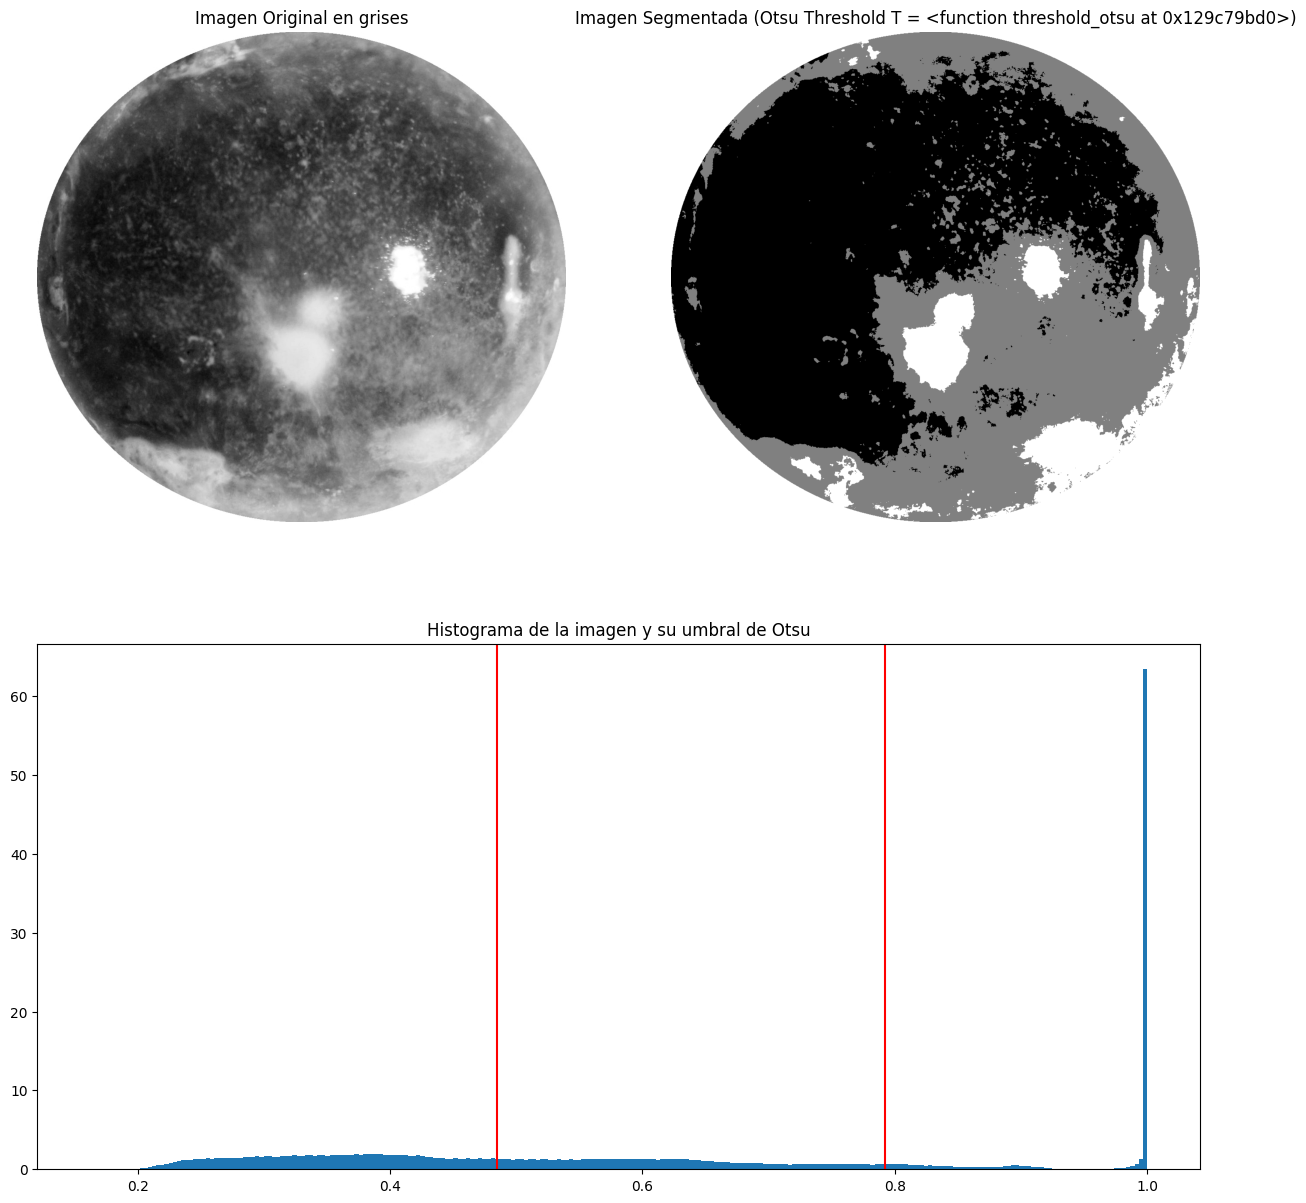

In [60]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import gridspec
from skimage.filters import threshold_multiotsu, threshold_otsu

# Encontrar los umbrales de Otsu:
I600_circle = sk.io.imread(os.path.join(path, "I600_circle.jpg"))
I600_gray = sk.color.rgb2gray(I600_circle)
thresholds = threshold_multiotsu(I600_gray)
threshold_otsu1 = thresholds[0]
threshold_otsu2 = thresholds[1]

print("Valor del Umbral de Otsu: ", threshold_otsu)

# Usando los umbrales, se generan 3 regiones
I_otsu = np.digitize(I600_gray, bins=thresholds)

# Graficar imagen original y segmentada por umbrales múltiples con el método Otsu
fig = plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(2, 2)

ax1 = fig.add_subplot(gs[0, 0])
ax1.imshow(I600_gray, cmap=plt.cm.gray)
ax1.set_title("Imagen Original en grises")
ax1.set_axis_off()

ax2 = fig.add_subplot(gs[0, 1])
ax2.imshow(I_otsu, cmap=plt.cm.gray)
ax2.set_title("Imagen Segmentada (Otsu Threshold T = {})".format(threshold_otsu))
ax2.set_axis_off()

ax3 = fig.add_subplot(gs[1, :])
ax3.hist(I600_gray.ravel(), bins=256, density=True)
ax3.axvline(threshold_otsu1, color="r")
ax3.axvline(threshold_otsu2, color="r")
ax3.set_title("Histograma de la imagen y su umbral de Otsu")
plt.show()

### Algoritmo k-Means

El algoritmo de K-means o K-means clustering es un méthod de cuantificación vectorial, originalmente aplicado en procesamiento de señales, que tiene como objetivo dividir n observaciones en k grupos en los que cada observación pertenece al grupo con la media más cercana (centros de grupo o centroide de grupo). Esto da como resultado una partición del espacio de datos en celdas Voronoi.

La agrupación de k-means minimiza las varianzas dentro del grupo (distancias euclidianas al cuadrado).

**Link:** https://www.unioviedo.es/compnum/laboratorios_py/kmeans/kmeans.html

Metodología:

  [1] Especificar el número de clusters $k$ a ser determinados en los datos.

  [2] Asignar valores iniciales para los centroides del cluster $\mu^0_1,\dots,\mu^0_k$ (pueden ser aleatorios o determinados aproximadamente).

  [3] Asignar cada observación al cluster más cercano (distancia euclideana).

  [4] Recalcular el centroide de cada cluster de las observaciones asignadas $\mu^1_1,\dots,\mu^1_k$.

  [5] Repetir los pasos 3-4 hasta que los centroides no cambien significativamente. Obtener el agrupamiento final $\mu^n_1,\dots,\mu^n_k$, donde $n$ es el número de iterations.

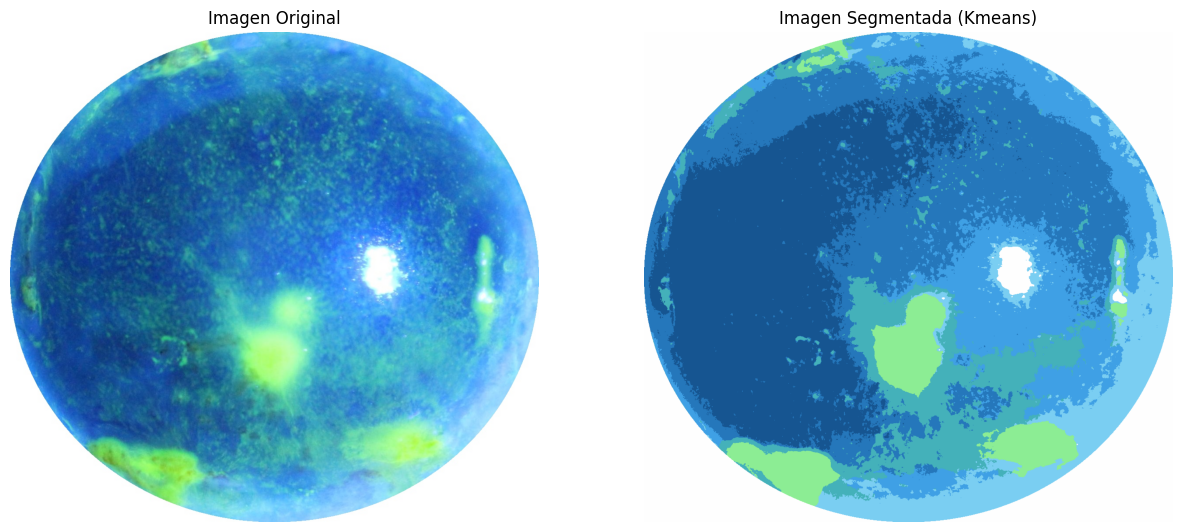

In [61]:
import numpy as np
from sklearn.cluster import KMeans

height, width, _ = I600_circle.shape
image = I600_circle
pixels = image.reshape((-1, 3))

kmeans = KMeans(n_clusters=7, max_iter=100, random_state=None)
kmeans.fit(pixels)

centers = np.uint8(kmeans.cluster_centers_)
labels = kmeans.labels_

segmented_image = centers[labels].reshape((height, width, 3))

fig = plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(1, 2)

ax1 = fig.add_subplot(gs[0, 0])
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title("Imagen Original")
ax1.set_axis_off()

ax2 = fig.add_subplot(gs[0, 1])
ax2.imshow(segmented_image, cmap=plt.cm.gray)
ax2.set_title("Imagen Segmentada (Kmeans)")
ax2.set_axis_off()

plt.show()


Se puede observar que la segmentación por K-Means al utilizar 7 clusters logra definir de una manera clara las úlceras en tonalidad verde.

# 3. Extracción de características regionales.

La caracterización cuantitativa de una imagen requiere la extracción de propiedades regionales relevantes de la imagen. Este proceso se conoce como **extracción de características**.

Existen varios enfoques de extracción de características y en esta sesión cubriremos los más importantes:

- Propiedades regionales básicas: basadas en la forma, intensidad, color, tamaño, etc.

- Propiedades regionales avanzadas (análisis de textura): Basado en propiedades estadísticas de la distribución de píxeles en la región: Homogeneidad, entropía, uniformidad, etc.

## 3.1. Propiedades basadas en forma



### Paso 1: Segmentación y etiquetado

En los métodos de extracción de características regionales generalmente se comienza con una imagen segmentada con regiones u objetos etiquetados. Para este análisis utilizaremos los generados anteriomente basado en :

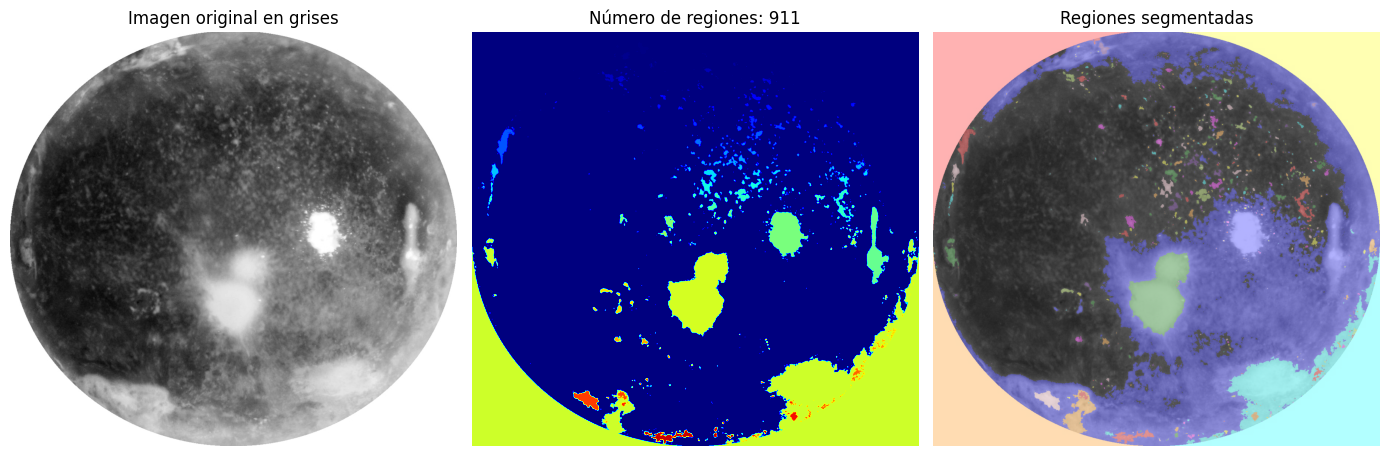

In [62]:
from skimage.color import label2rgb, rgb2gray
from skimage.filters import threshold_otsu
from skimage.measure import label

# Etiquetar las regiones de la imagen obtenida por otsu de umbrales multiples:
label_image, nregions = label(I_otsu, return_num=True)
image_label_overlay = label2rgb(
    label_image,
    image=I600_gray,
)

# Obtener figuras:
fig, axes = plt.subplots(1, 3, figsize=(14, 9))
ax = axes.ravel()
ax[0].imshow(I600_gray, cmap=plt.cm.gray)
ax[0].set_title("Imagen original en grises")
ax[1].imshow(label_image, cmap=plt.cm.jet)
ax[1].set_title("Número de regiones: {}".format(nregions))
ax[2].imshow(image_label_overlay, cmap=plt.cm.jet)
ax[2].set_title("Regiones segmentadas")

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()
plt.tight_layout()
plt.show()

Obteniendo las propiedades de forma en un pandas dataframe

In [63]:
import pandas as pd
from skimage import measure

props = measure.regionprops_table(
    label_image, properties=["label", "area", "eccentricity", "extent"]
)

df_propietats = pd.DataFrame(props)
df_propietats.head(10).sort_values("area", ascending=False)


label      area  eccentricity    extent
1      2  393159.0      0.640010  0.293737
0      1   72621.0      0.862249  0.237647
2      3   72476.0      0.861875  0.237172
5      6     460.0      0.774153  0.463710
6      7      30.0      0.793127  0.625000
9     10       9.0      0.694588  0.750000
3      4       3.0      0.816497  0.750000
8      9       2.0      1.000000  1.000000
4      5       1.0      0.000000  1.000000
7      8       1.0      0.000000  1.000000

<Axes: xlabel='eccentricity', ylabel='area'>

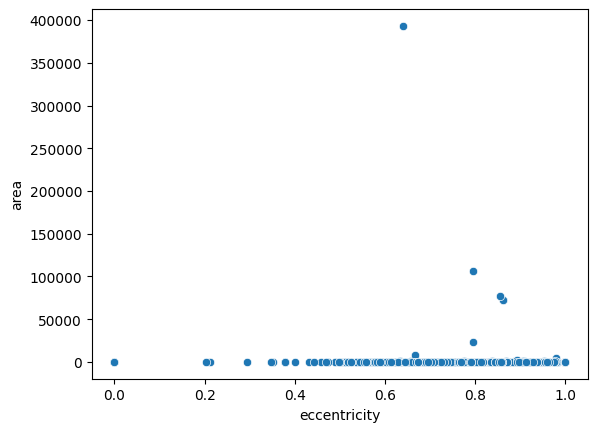

In [64]:
import seaborn as sns

sns.scatterplot(x="eccentricity", y="area", data=df_propietats)

### Paso 2: Obtener propiedades regionales:



In [65]:
import numpy as np
from skimage.measure import regionprops

props = regionprops(label_image)

Ahora es posible revisar algunas de las propiedades disponibles. Por ejemplo la región más extensa que es la 4, tiene las siguientes propiedades:

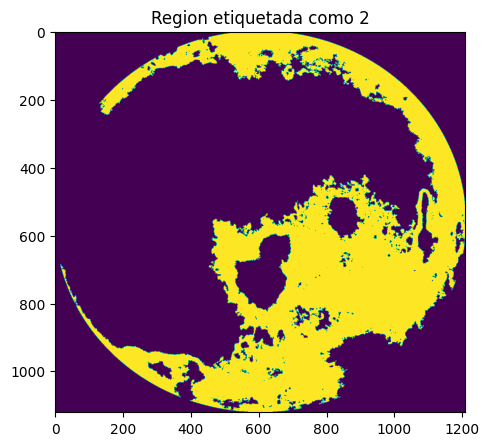

******* Region  2  *******
Area of Region: 72621.0 pixels
Centroiod of Region: (np.float64(124.60848790294818), np.float64(134.48229850869583)) 
Eccentricity of Region: 0.8622485161902657
Major Axis Length of Region: 551.4016854055585 pixels
Minor Axis Length of Region: 279.27692274306156 pixels
Perimeter of Region: 2017.56053326821 pixels
Orientation of Region: -0.8492447109006421 degrees


In [66]:
fig, ax = plt.subplots(figsize=(5, 5))
# Elegir la región
numregion = 2
ax.imshow(label_image == numregion)
title = "Region etiquetada como " + str(numregion)
ax.set_title(title)
plt.tight_layout()
plt.show()

print("******* Region ", numregion, " *******")
print("Area of Region: {} pixels".format(props[0].area))
print("Centroiod of Region: {} ".format(props[0].centroid))
print("Eccentricity of Region: {}".format(props[0].eccentricity))
print("Major Axis Length of Region: {} pixels".format(props[0].major_axis_length))
print("Minor Axis Length of Region: {} pixels".format(props[0].minor_axis_length))
print("Perimeter of Region: {} pixels".format(props[0].perimeter))
print("Orientation of Region: {} degrees".format(props[0].orientation))

### Paso 3: Inspección de las regiones:

Como existen demasiadas regiones (730), es adecuado descartar las que corresponden a pequeños artefactos en la imagen. Esto se hace evidente cuando se imprime el área iterando sobre las regiones. Nótese que la región número 1 se guarda en props[0].

In [67]:
for ireg in range(0, nregions):
    print("Area of region {} is = {} pixels".format(ireg + 1, props[ireg].area))

Area of region 1 is = 72621.0 pixels
Area of region 2 is = 393159.0 pixels
Area of region 3 is = 72476.0 pixels
Area of region 4 is = 3.0 pixels
Area of region 5 is = 1.0 pixels
Area of region 6 is = 460.0 pixels
Area of region 7 is = 30.0 pixels
Area of region 8 is = 1.0 pixels
Area of region 9 is = 2.0 pixels
Area of region 10 is = 9.0 pixels
Area of region 11 is = 1.0 pixels
Area of region 12 is = 285.0 pixels
Area of region 13 is = 3.0 pixels
Area of region 14 is = 1.0 pixels
Area of region 15 is = 2.0 pixels
Area of region 16 is = 1.0 pixels
Area of region 17 is = 12.0 pixels
Area of region 18 is = 1.0 pixels
Area of region 19 is = 6.0 pixels
Area of region 20 is = 1.0 pixels
Area of region 21 is = 6.0 pixels
Area of region 22 is = 1.0 pixels
Area of region 23 is = 6.0 pixels
Area of region 24 is = 6.0 pixels
Area of region 25 is = 2.0 pixels
Area of region 26 is = 23.0 pixels
Area of region 27 is = 42.0 pixels
Area of region 28 is = 4.0 pixels
Area of region 29 is = 1.0 pixels
Ar

Es obvio que las regiones con un área de pocos píxeles deben considerarse artefactos espurios de la segmentación. Una forma confiable de inspeccionar las características regionales es representar el histograma de las características:

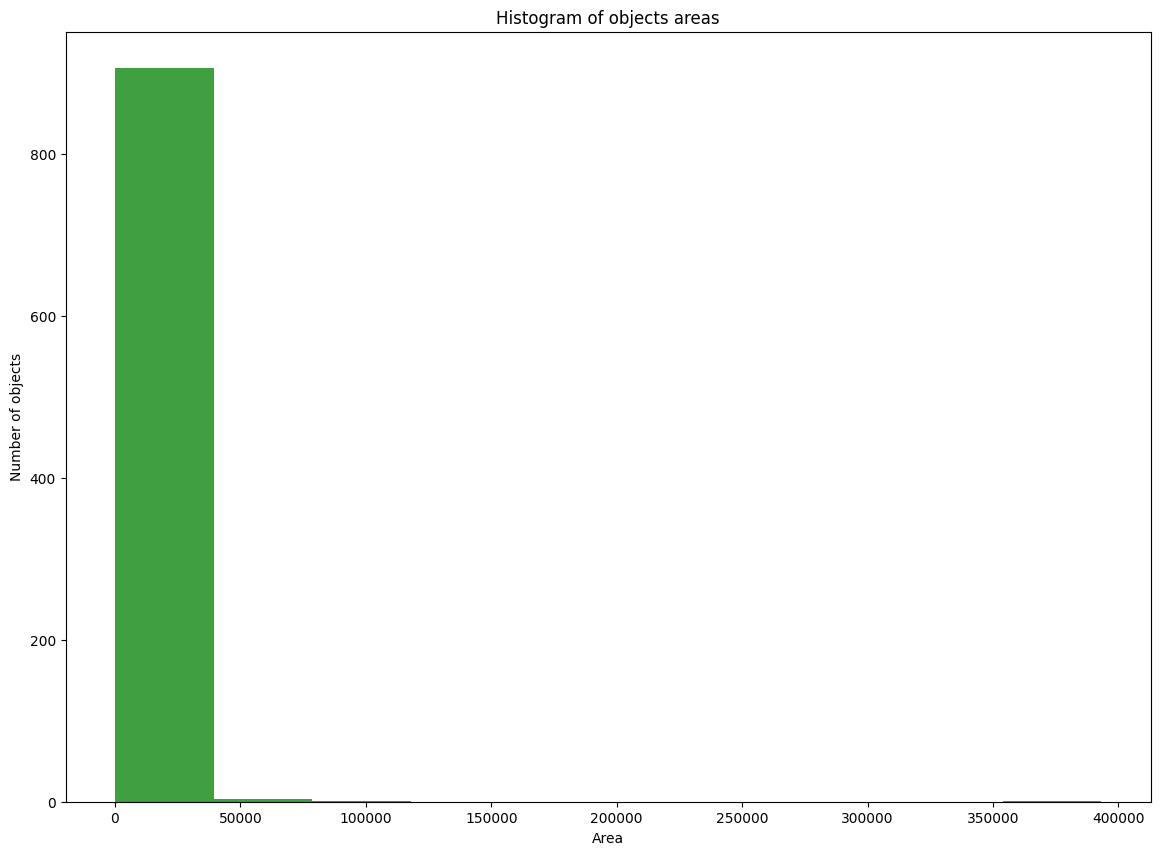

In [68]:
import numpy as np

area = np.zeros(nregions)
for i in range(0, nregions):
    area[i] = props[i].area

# Graficar histograma de las áreas
fig = plt.figure(figsize=(14, 10))
n, bins, patches = plt.hist(area, density=False, facecolor="g", alpha=0.75)

plt.xlabel("Area")
plt.ylabel("Number of objects")
plt.title("Histogram of objects areas")
plt.show()

 Ahora es posible identificar que se tienen muchas regiones de solo algunos pixeles:

In [69]:
ind_large = np.where(area > 3000)
ind_lregions = (
    np.array(ind_large) + 1
)  # Note: region 1 is placed in component 0 or the props variable
area_large = area[ind_large]
print("There are {} large objects".format(len(area_large)))
print("Large objects correspond to regions: {}".format(ind_lregions))
print("The areas of the large objects are: {}".format(area_large))

ind_small = np.where(area < 3000)
area_small = area[ind_small]
ind_sregions = np.array(ind_small) + 1
print("There are {} small objects".format(len(area_small)))
print("Small objects correspond to regions: {}".format(ind_sregions))

There are 8 large objects
Large objects correspond to regions: [[  1   2   3 432 452 547 548 555]]
The areas of the large objects are: [ 72621. 393159.  72476.   4668.   8394.  76791. 106791.  22834.]
There are 903 small objects
Small objects correspond to regions: [[  4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20  21
   22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39
   40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57
   58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75
   76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93
   94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111
  112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129
  130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147
  148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165
  166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 18

### Paso 4: Remover regions demasiado pequeñas y extremos de la figura:



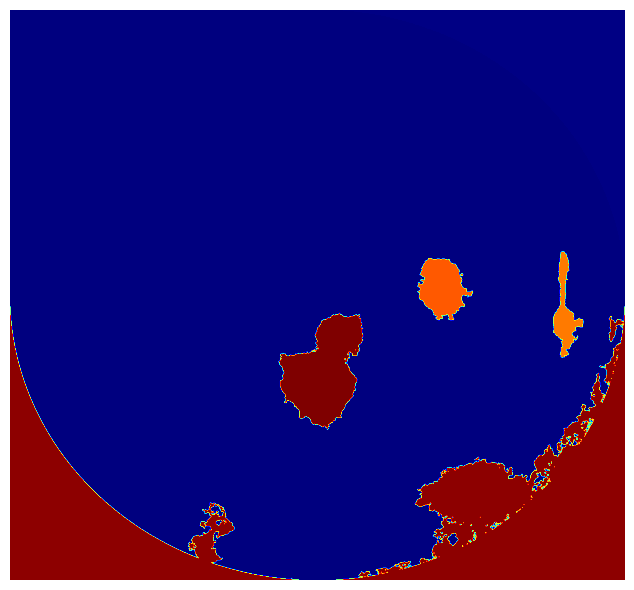

In [70]:
for i in np.squeeze(ind_small):  # loop sobre pequeñas regiones
    iregion = i + 1
    label_image[label_image == iregion] = (
        0  # etiquetar las regiones pequeñas como background o zero
    )

ind_extreme = [1, 4]
for i in np.squeeze(ind_extreme):  # loop sobre regiones grandes
    iregion = i + 1
    label_image[label_image == iregion] = (
        0  # etiquetar las regiones grandes como background o zero
    )

image_label_overlay = label2rgb(
    label_image, image=I600_gray
)  # generate again the colormap assignment

fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(label_image, cmap=plt.cm.jet)
ax.set_axis_off()
plt.tight_layout()
plt.show()

### Paso 5: Obtener las propiedades de la región final:

Representa el **centroide y el cuadro delimitador** de cada objeto en la imagen:

The number of final regions is 7


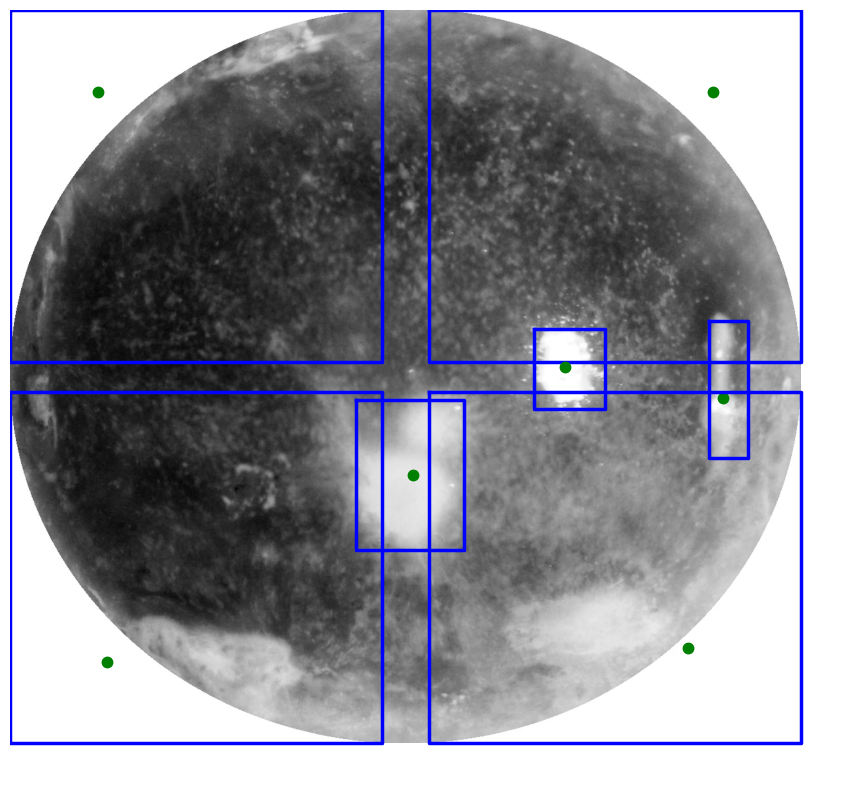

: 

In [71]:
import math

from skimage.measure import regionprops

props = regionprops(
    label_image
)  # Obtener de nuevo las propiedades después de remover la regiones espurias
print("The number of final regions is {}".format(len(props)))

fig, ax = plt.subplots(figsize=(14, 10))
ax.imshow(I600_gray, cmap=plt.cm.gray)

for p in props:
    y0, x0 = p.centroid
    ax.plot(x0, y0, ".g", markersize=15)

    minr, minc, maxr, maxc = p.bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    ax.plot(bx, by, "-b", linewidth=2.5)

ax.set_axis_off()
plt.show()

## 3.3. Extracción de características:

Matriz de co-ocurrencia:

Representa el **centroide y el cuadro delimitador** de cada objeto en la imagen: Cada componente de la matriz de coocurrencia g[i,j,d,theta] representa el número de veces que el nivel de gris j ocurre a una distancia d y en un ángulo theta del nivel de gris i:

In [56]:
from skimage.feature import graycomatrix

image = np.array(
    [[0, 0, 1, 1], [0, 0, 1, 1], [0, 2, 2, 2], [2, 2, 3, 3]], dtype=np.uint8
)
g = graycomatrix(image, [1], [0], levels=4, normed=False, symmetric=False)
print(image)
print(
    "Number of times that a grayscale level zero has a neighbour with value zero at a distance of 1 pixel to the right (angle equal zero): {}".format(
        g[0, 0, 0, 0]
    )
)
print(
    "Number of times that a grayscale level zero has a neighbour with value 1 at a distance of 1 pixel to the right (angle equal zero): {}".format(
        g[0, 1, 0, 0]
    )
)
print(
    "Number of times that a grayscale level 2 has a neighbour with value 2 at a distance of 1 pixel to the right (angle equal zero): {}".format(
        g[2, 2, 0, 0]
    )
)
print(
    "Number of times that a grayscale level 2 has a neighbour with value 0 at a distance of 1 pixel to the right (angle equal zero): {}".format(
        g[2, 0, 0, 0]
    )
)

[[0 0 1 1]
 [0 0 1 1]
 [0 2 2 2]
 [2 2 3 3]]
Number of times that a grayscale level zero has a neighbour with value zero at a distance of 1 pixel to the right (angle equal zero): 2
Number of times that a grayscale level zero has a neighbour with value 1 at a distance of 1 pixel to the right (angle equal zero): 2
Number of times that a grayscale level 2 has a neighbour with value 2 at a distance of 1 pixel to the right (angle equal zero): 3
Number of times that a grayscale level 2 has a neighbour with value 0 at a distance of 1 pixel to the right (angle equal zero): 0


Una vez que se tiene la GLCM es posible calcular las diferentes propiedades de textura:

Las propiedades se calculan de la siguiente manera:

- 'contraste': $\sum_{i,j=0}^{levels-1} P_{i,j}(i-j)^2$

- 'disimilitud': $\sum_{i,j=0}^{levels-1}P_{i,j}|i-j|$

- 'homogeneidad': $\sum_{i,j=0}^{levels-1}\frac{P_{i,j}}{1+(i-j)^2}$

- 'ASM': $\sum_{i,j=0}^{levels-1} P_{i,j}^2$

- 'energía':$\sqrt{ASM}$

- 'correlación': $\sum_{i,j=0}^{levels-1} P_{i,j}\left[\frac{(i-\mu_i) (j-\mu_j)}{\sqrt{(\sigma_i^2)(\sigma_j^2)}}\right]$

   

1. Estimando la matriz de co-ocurrencia de niveles de gris de cada una de las regiones de la imagen:

In [58]:
import matplotlib.pyplot as plt
from skimage import data
from skimage.feature import graycomatrix, graycoprops
from skimage.util import img_as_ubyte

props = regionprops(
    label_image, intensity_image=I600_gray
)  # Obtener de nuevo las propiedades después de remover las regiones pequeñas

nregions = len(props)

iregion = 0
props_texture = np.zeros((nregions, 5))
for p in props:
    minr, minc, maxr, maxc = p.bbox
    I = I600_gray[minc:maxc, minr:maxr]
    I = img_as_ubyte(I)
    g = graycomatrix(I, [1], [0], levels=None, normed=True, symmetric=True)
    contrast = graycoprops(g, "contrast")
    dissimilarity = graycoprops(g, "dissimilarity")
    homogeneity = graycoprops(g, "homogeneity")
    energy = graycoprops(g, "energy")
    correlation = graycoprops(g, "correlation")

    props_texture[iregion, 0] = contrast
    props_texture[iregion, 1] = dissimilarity
    props_texture[iregion, 2] = homogeneity
    props_texture[iregion, 3] = energy
    props_texture[iregion, 4] = correlation

    iregion = iregion + 1

# Export all features as a Pandas dataframe:
import pandas as pd

df = pd.DataFrame(
    props_texture,
    columns=["Contraste", "disimilitud", "homogeneidad", "energía", "correlación"],
)
df.to_excel("Texture_features.xlsx")
df


/var/folders/tm/t6qccs7s1zdd01dqc9zssqxm0000gn/T/ipykernel_26867/3382687445.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  props_texture[iregion, 0] = contrast
/var/folders/tm/t6qccs7s1zdd01dqc9zssqxm0000gn/T/ipykernel_26867/3382687445.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  props_texture[iregion, 1] = dissimilarity
/var/folders/tm/t6qccs7s1zdd01dqc9zssqxm0000gn/T/ipykernel_26867/3382687445.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pro

Contraste  disimilitud  homogeneidad   energía  correlación
0  36.641579     1.901284      0.512320  0.219634     0.996643
1  24.680559     1.703620      0.546683  0.260372     0.997843
2   8.345700     1.416636      0.512996  0.076003     0.982734
3   7.892865     2.143832      0.364180  0.038444     0.994557
4  15.630026     2.164090      0.441937  0.128126     0.997277
5   6.634998     1.477890      0.529400  0.145063     0.998056
6   7.226089     1.858037      0.432236  0.037984     0.997192

## **Bibliografía**

Deng, L., Lyu, J., Huang, H. et al. The SUSTech-SYSU dataset for automatically segmenting and classifying corneal ulcers. Sci Data 7, 23 (2020). https://doi.org/10.1038/s41597-020-0360-7

Wang, Z., Lyu, J., Luo, W., Tang, X. (2021). Adjacent Scale Fusion and Corneal Position Embedding for Corneal Ulcer Segmentation. In: Fu, H., Garvin, M.K., MacGillivray, T., Xu, Y., Zheng, Y. (eds) Ophthalmic Medical Image Analysis. OMIA 2021. Lecture Notes in Computer Science(), vol 12970. Springer, Cham. https://doi.org/10.1007/978-3-030-87000-3_1
